In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

def generate_corr_stats(
    invcov,
    sampsize=100
):
    covmat = np.linalg.inv(invcov)
    samp = np.random.multivariate_normal([0,0,0],covmat,size=(sampsize,sampsize))
    
    sampcov=np.zeros((3,3,sampsize))
    sampcorr=np.zeros((3,3,sampsize))
    
    covvect=np.zeros((sampsize,6))
    invcovvect=np.zeros((sampsize,6))
    corrvect=np.zeros((sampsize,6))
    invcorrvect=np.zeros((sampsize,6))
    
    for i in range(sampsize):
        sampcov = np.cov(samp[:,i,:],rowvar=False)
        sampcorr = np.corrcoef(samp[:,i,:],rowvar=False)
        
        covvect[i,:] = sampcov[np.triu_indices(3)]
        invcovvect[i,:] = np.linalg.inv(sampcov)[np.triu_indices(3)]
        corrvect[i,:] = sampcorr[np.triu_indices(3)]
        invcorrvect[i,:] = np.linalg.inv(sampcorr)[np.triu_indices(3)]
        
    
    covvect=covvect.flatten()
    invcovvect=invcovvect.flatten()
    corrvect=corrvect.flatten()
    invcorrvect=invcorrvect.flatten()

    return covvect,invcovvect,corrvect,invcorrvect

In [2]:
sampsize=50


precmat=np.array([[2,-1,0],[-1,2,-1],[0,-1,2]])
absprec=np.array([[1,1,0],[1,1,1],[0,1,1]])
absvect=absprec[np.triu_indices(3)]

abscov=np.array([[1,1,0],[1,1,1],[0,1,1]])
abscov=abscov[np.triu_indices(3)]

abscov = np.tile(abscov,sampsize)
absvect = np.tile(absvect,sampsize)
cov,invcov,corr,invcorr = generate_corr_stats(precmat,sampsize)

fpr1,tpr1,_=metrics.roc_curve(absvect,cov,drop_intermediate=False)
fpr2,tpr2,_=metrics.roc_curve(absvect,np.absolute(invcov),drop_intermediate=False)
fpr3,tpr3,_=metrics.roc_curve(absvect,corr,drop_intermediate=False)
fpr4,tpr4,_=metrics.roc_curve(absvect,invcorr,drop_intermediate=False)

auc1=metrics.auc(fpr1, tpr1)
auc2=metrics.auc(fpr2, tpr2)
auc3=metrics.auc(fpr3, tpr3)
auc4=metrics.auc(fpr4, tpr4)

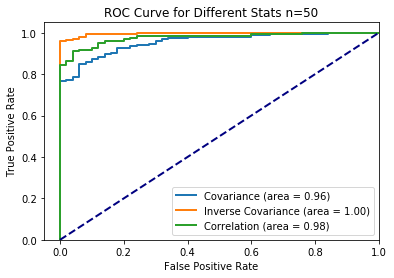

In [3]:
plt.figure()
lw = 2
plt.plot(fpr1, tpr1,
         lw=lw, label='Covariance (area = %0.2f)' % auc1)
plt.plot(fpr2, tpr2,
         lw=lw, label='Inverse Covariance (area = %0.2f)' % auc2)
plt.plot(fpr3, tpr3,
         lw=lw, label='Correlation (area = %0.2f)' % auc3)
#plt.plot(fpr4, tpr4,
#         lw=lw, label='Inverse Correlation (area = %0.2f)' % auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Stats n=50')
plt.legend(loc="lower right")
plt.show()